In [1]:
#import transformers as ppb
import torch
from transformers import BertModel
from transformers import BertTokenizer
from sklearn.pipeline import Pipeline

https://towardsdatascience.com/build-a-bert-sci-kit-transformer-59d60ddd54a5
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.datasets import load_files
#nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [3]:
from typing import Callable, List, Optional, Tuple
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch


class BertTransformer(BaseEstimator, TransformerMixin):

    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 512,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(text,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length
                                                    )["input_ids"]
        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)
        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)
        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [4]:
df = pd.read_csv("C:/Users/Lingshu/Documents/Projects/sml_content_analysis/data/training_text_no_other_1980-2019.csv")
df = df.rename(columns={"sudo": "sudon", "sudo2": "sudo"})
df['sudo'] = df['sudo'].map({'g':0, 's':1, 'm':1})

In [5]:
df = shuffle(df, random_state = 111)

df_train = df.sample(frac=0.9, random_state=115)
df_test = df.drop(df_train.index)

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

bert_transformer = BertTransformer(tokenizer, bert_model)
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")
model = Pipeline(
    [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ]
)
model.fit(df_train["text"], df_train["sudo"])

NameError: name 'bert_model' is not defined

In [32]:
stemmer = WordNetLemmatizer()

def text_process(text):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(text))
    document = re.sub(r'https?:\S+|http?:\S', '', document)
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    # Converting to Lowercase
    document = document.lower()
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    return(document)

In [92]:
%%time
documents_train = df_train.text.apply(lambda x: text_process(x))

documents_test = []
for i in range(0, len(df_test.text)):
    document = text_process(df_test.text.values[i])
    documents_test.append(document)

Wall time: 4.5 s


In [ ]:
bert_transformer = BertTransformer(tokenizer, bert_model)

In [93]:
X_train = bert_transformer.transform(documents_train).numpy()
X_test = bert_transformer.transform(documents_test).numpy()

In [94]:
y_train = df_train['sudo']
y_test = df_test['sudo']

In [56]:
type(X_train)

numpy.ndarray

In [95]:
md = svm.SVC(decision_function_shape='ovo', random_state=111)
md.fit(X_train, y_train)
print(md.score(X_train, y_train))
print(md.score(X_test, y_test))

0.8262380538662033
0.828125


In [102]:
md = LogisticRegression(random_state=111, max_iter = 1000)
md.fit(X_train, y_train)

print("train accuracy: ", md.score(X_train, y_train))
print("test accuracy: ", md.score(X_test, y_test))

train accuracy:  0.9600347523892268
test accuracy:  0.703125


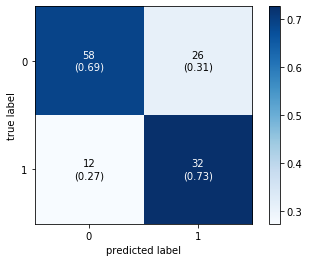

In [103]:
y_pred = md.predict(X_test)
sv_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=sv_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [97]:
sm = SMOTE(random_state = 111)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
X_test_sm, y_test_sm = sm.fit_sample(X_test, y_test)

In [98]:
md = svm.SVC(decision_function_shape='ovo', random_state=111)
md.fit(X_train_sm, y_train_sm)
print(md.score(X_train_sm, y_train_sm))
print(md.score(X_test_sm, y_test_sm))

0.8504464285714286
0.7857142857142857


In [105]:
md = LogisticRegression(random_state=111, max_iter = 1000)
md.fit(X_train_sm, y_train_sm)

print("train accuracy: ", md.score(X_train_sm, y_train_sm))
print("test accuracy: ", md.score(X_test_sm, y_test_sm))

train accuracy:  0.9680059523809523
test accuracy:  0.7202380952380952


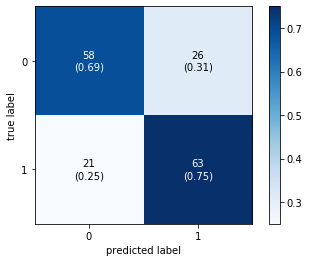

In [106]:
y_pred = md.predict(X_test_sm)
sv_matrix = confusion_matrix(y_test_sm, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=sv_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [14]:
df = pd.read_csv("C:/Users/Lingshu/Documents/Projects/sml_content_analysis/data/training_text_no_other_1980-2019.csv")

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_dict = tokenizer.encode_plus(
    "hi my name is nicolas",
    add_special_tokens=True,
    max_length=5
    )

In [3]:
tokenized_dict

{'input_ids': [101, 7632, 2026, 2171, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [4]:
bert_model = BertModel.from_pretrained("bert-base-uncased")
tokenized_text = torch.tensor(tokenized_dict["input_ids"])
with torch.no_grad():
  embeddings = bert_model(torch.tensor(tokenized_text.unsqueeze(0)))

C:\Users\Lingshu\.conda\envs\my_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [5]:
get_cls = lambda x: x[0][:, 0, :].squeeze()

In [6]:
flatten_embed = lambda x: torch.flatten(x[0])

In [10]:
flatten_embed(get_cls(embeddings))

tensor([0.0852])

In [11]:
features = embeddings[0][:,0,:].numpy()